In [1]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import datetime
from pyspark import	SparkContext

## Adicionando os Dados

In [33]:
# iniciando uma sessão 
ssql = SparkSession.builder.appName("Client").getOrCreate()

sc = SparkContext.getOrCreate()

In [34]:
# Carregando o dataset utilizado
data = ssql.read.csv('Data.csv', header=True)

# Carregando o dataset utilizado
ssql.read.csv('Data.csv', header=True).createOrReplaceTempView("Data")

In [22]:
data.show()

+---+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+---------------+---------+--------------------+------+-------------+--------------------+--------------------+
|_c0|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page|   registration|sessionId|                song|status|           ts|           userAgent|              userId|
+---+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+---------------+---------+--------------------+------+-------------+--------------------+--------------------+
|  0|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000.0|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|                  30|
|  1|    Fiv

In [23]:
print(f'O data-set possui {data.count()} fileiras')
print(f'e {len(data.columns)} colunas')

O data-set possui 286500 fileiras
e 19 colunas


In [69]:
data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: string (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: string (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: string (nullable = true)
 |-- song: string (nullable = true)
 |-- status: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = false)
 |-- paid: integer (nullable = false)
 |-- Feminino: string (nullable = false)
 |-- method_GET: integer (nullable = false)
 |-- ts: string (nullable = true)
 |-- registration: string (nullable = true)



## EDA

Temos as informações de quais foram as movimentações no site. Sendo a de nosso interesse "Cancellation Confirmation" que foram as contas encerradas pelos clientes

In [25]:
ssql.sql("select page, count(page) page "+
         "from data "+
         "group by page "+
         "order by count(page) desc").show(truncate=False)

+-------------------------+------+
|page                     |page  |
+-------------------------+------+
|NextSong                 |228108|
|Home                     |14457 |
|Thumbs Up                |12551 |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|Roll Advert              |3933  |
|Login                    |3241  |
|Logout                   |3226  |
|Thumbs Down              |2546  |
|Downgrade                |2055  |
|Help                     |1726  |
|Settings                 |1514  |
|About                    |924   |
|Upgrade                  |499   |
|Save Settings            |310   |
|Error                    |258   |
|Submit Upgrade           |159   |
|Submit Downgrade         |63    |
|Cancel                   |52    |
|Cancellation Confirmation|52    |
+-------------------------+------+
only showing top 20 rows



Podemos perceper que há grande quantia de nulls, e que há pelo menos 3 colunas com as mesmas quantias, provavelmente se uma determinada coluna estiver com null as outras também estarão

In [26]:
# Loop para contabilizar quantia de nulls em cada coluna
for i in data.columns[1:]:
    nulls = data.filter(f'{i} is NULL').count()
    print(f'Quantia de Nulls na coluna {i} ', nulls)

Quantia de Nulls na coluna artist  58392
Quantia de Nulls na coluna auth  0
Quantia de Nulls na coluna firstName  8346
Quantia de Nulls na coluna gender  8346
Quantia de Nulls na coluna itemInSession  0
Quantia de Nulls na coluna lastName  8346
Quantia de Nulls na coluna length  58392
Quantia de Nulls na coluna level  0
Quantia de Nulls na coluna location  8346
Quantia de Nulls na coluna method  0
Quantia de Nulls na coluna page  0
Quantia de Nulls na coluna registration  8346
Quantia de Nulls na coluna sessionId  0
Quantia de Nulls na coluna song  58392
Quantia de Nulls na coluna status  0
Quantia de Nulls na coluna ts  0
Quantia de Nulls na coluna userAgent  8346
Quantia de Nulls na coluna userId  8346


Os valores que faltam podem seguir um certo padrão já que seguem uma sequência, esse problema será resolvido nas seguintes partes levando essa informação em conta, pois irei usar uma forma específica para lidar com os valores faltantes

In [27]:
# Quando um das 3 colunas é null as outras duas também serão
ssql.sql("select artist, length, song "+
         "from data "+
         "where artist is null and "+
         "length is null and "+
         "song is null").count()

58392

In [28]:
# Quando um das 7 colunas é null as outras seis também serão
ssql.sql("select firstName, gender, lastName, location, registration, userAgent, userID "+
         "from data "+
         "where gender is null and firstName is null and lastName is null and registration is null and "+
         "userAgent is null and userID is null").count()

8346

In [29]:
# Ao selecionar todas a variáveis que possuem null
ssql.sql("select artist, length, song, firstName, gender, lastName, location, registration, userAgent, userID "+
         "from data "+
         "where artist is null and "+
         "length is null and "+
         "song is null and "+
         "gender is null and firstName is null and lastName is null and "+
         "registration is null and userAgent is null and userID is null").count()

8346

In [30]:
# Quantia de usuários do serviço, separados por sexo
ssql.sql("select gender,count(distinct userID) as num_userID "+
         "from data "+
         "group by gender "+
         "order by count(distinct userID) desc").show()

+------+----------+
|gender|num_userID|
+------+----------+
|     M|        46|
|     F|        43|
|  null|         0|
+------+----------+



In [31]:
# Diferentes auth
ssql.sql("select auth, count(auth) as authD "+
         "from data "+
         "group by auth "+
         "order by count(auth) desc").show()

+----------+------+
|      auth| authD|
+----------+------+
| Logged In|278102|
|Logged Out|  8249|
|     Guest|    97|
| Cancelled|    52|
+----------+------+



In [32]:
ssql.sql("select itemInSession, count(itemInSession) "+
         "from data "+
         "group by itemInSession "+
         "order by count(itemInSession) desc").show()

+-------------+--------------------+
|itemInSession|count(itemInSession)|
+-------------+--------------------+
|            0|                3278|
|            1|                3125|
|            2|                3067|
|            3|                3013|
|            4|                2977|
|            5|                2925|
|            6|                2886|
|            7|                2857|
|            8|                2816|
|            9|                2771|
|           10|                2717|
|           11|                2672|
|           12|                2636|
|           13|                2600|
|           14|                2561|
|           15|                2523|
|           16|                2497|
|           17|                2461|
|           18|                2417|
|           19|                2381|
+-------------+--------------------+
only showing top 20 rows



In [33]:
# Transformando uma variável de str para double
data = data.withColumn("length", data.length.cast('double'))

# Transformando uma variável de str para double
data = data.withColumn("_c0", data._c0.cast('int'))

In [34]:
# Criando um data frame no formato do pandas
data_pd = data.toPandas()

<Axes: ylabel='Frequency'>

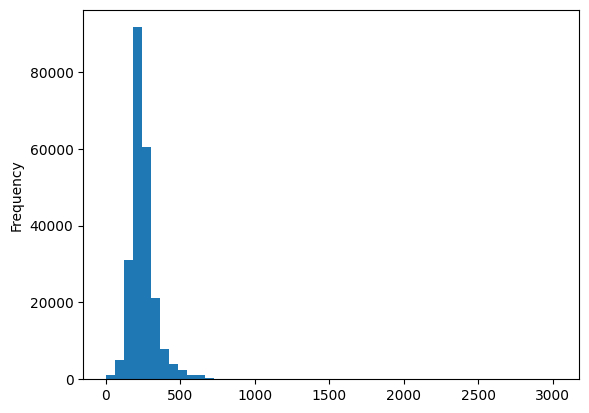

In [35]:
# hist da duração das musicas por segundo
data_pd['length'].plot.hist(bins=50)

In [36]:
data_pd['length'].describe()

count    228108.000000
mean        249.117182
std          99.235179
min           0.783220
25%         199.888530
50%         234.500770
75%         277.158730
max        3024.665670
Name: length, dtype: float64

A forma que a localização foi salva não permite, sem que haja um tratamento, a distribuição dos usuários por região

In [37]:
# Localização dos usuários do serviço
ssql.sql("select location,count(location) as location "+
         "from data "+
         "group by location "+
         "order by count(location) desc").show(truncate=False)

+-------------------------------------------+--------+
|location                                   |location|
+-------------------------------------------+--------+
|Los Angeles-Long Beach-Anaheim, CA         |30131   |
|New York-Newark-Jersey City, NY-NJ-PA      |23684   |
|Boston-Cambridge-Newton, MA-NH             |13873   |
|Houston-The Woodlands-Sugar Land, TX       |9499    |
|Charlotte-Concord-Gastonia, NC-SC          |7780    |
|Dallas-Fort Worth-Arlington, TX            |7605    |
|Louisville/Jefferson County, KY-IN         |6880    |
|Philadelphia-Camden-Wilmington, PA-NJ-DE-MD|5890    |
|Chicago-Naperville-Elgin, IL-IN-WI         |5114    |
|St. Louis, MO-IL                           |4858    |
|Phoenix-Mesa-Scottsdale, AZ                |4846    |
|Vineland-Bridgeton, NJ                     |4825    |
|Wilson, NC                                 |4659    |
|Denver-Aurora-Lakewood, CO                 |4453    |
|Ionia, MI                                  |4428    |
|San Anton

## Data Preprocessing

Com a exploração feita temos uma pequena noção do que deve ser ajeitado para termos os dados em um melhor formato. Para então, depois que tivermos esses dados melhores tratados poderemos explorar alguns detalhes finais, e voltar a processar os dados caso for necessário.

Iremos começar adicionando mais uma variável ao data set representando se determinado usuário deixou de usar o serviço (churn)

In [35]:
# Adicionando coluna int para churn
data = data.withColumn('churn', F.when((data.page == 'Cancellation Confirmation'), F.lit(1))\
                     .otherwise(F.lit(0)))
# Nova coluna int para pago ou não pago
data = data.withColumn('paid', F.when((data.level == 'paid'), F.lit(1))\
                     .otherwise(F.lit(0)))

# Nova coluna int para sexo feminino ou não(masculino)
data = data.withColumn('Feminino', F.when((data.gender == 'F'), F.lit(1))\
                       .when((data.gender == 'M'), F.lit(0)).otherwise('null'))

# O se o a chamda HTTP foi get ou não
data = data.withColumn('method_GET', F.when((data.method == 'GET'), F.lit(1))\
                     .otherwise(F.lit(0)))

Iremos fazer One-hot-encode em variáveis str com mais de 2 classes. Para usar o One_hot_encode iremos criar uma função, pois as que encontrei disponível em pyspark não atende as necessidades.

In [39]:
# Função para One_hot_encode
def One_hot_encode(data_set, coluna):
    for i in data_set.select(coluna).distinct().collect():
        data_set = data_set.withColumn(i[coluna]+' _One_hot', F.when((data_set[coluna] == i[coluna]), F.lit(1))\
                     .otherwise(F.lit(0)))
    return data_set

data = One_hot_encode(data, 'auth')

In [40]:
# Encluindo colunas que foram representadas de outra forma
data = data.drop('gender').drop('level').drop('method').drop('auth').drop('Cancelled One_hot')
# CancelledOne_hot = churn

In [41]:
data.show()

+---+--------------------+---------+-------------+--------+---------+--------------------+---------------+---------------+---------+--------------------+------+-------------+--------------------+--------------------+-----+----+--------+----------+-------------------+------------------+------------------+--------------+
|_c0|              artist|firstName|itemInSession|lastName|   length|            location|           page|   registration|sessionId|                song|status|           ts|           userAgent|              userId|churn|paid|Feminino|method_GET|Logged Out _One_hot|Cancelled _One_hot|Logged In _One_hot|Guest _One_hot|
+---+--------------------+---------+-------------+--------+---------+--------------------+---------------+---------------+---------+--------------------+------+-------------+--------------------+--------------------+-----+----+--------+----------+-------------------+------------------+------------------+--------------+
|  0|      Martha Tilston|    Colin| 

Registration e ts são variáveis do tipo date, porem não estão configuradas do jeito que lemos, então farei um processo para processa-los. Porem o caminho mais fácil está dando problemas, ao pesquisá-lo diz ser questão de versão em compatibilidade, podendo ser do java, python,  spark ou hadoop, testei em outras versões algum deles porem sem sucesso, então o caminho será um pouco mais longo

In [44]:
# Loop por toda coluna em ts passando os dados para %Y-%m-%d %H:%M:%S
count = 0
date1 = []
for i in data.select('ts').collect():
    date = datetime.datetime.fromtimestamp(int(i.ts) / 1000.0)\
        .strftime("%Y-%m-%d %H:%M:%S")
    date1.append(str(count)+','+date)
    count+=1
date1[:5]

['0,2018-09-30 21:01:57',
 '1,2018-09-30 21:03:00',
 '2,2018-09-30 21:06:34',
 '3,2018-09-30 21:06:56',
 '4,2018-09-30 21:11:16']

In [45]:
# Loop por toda coluna em restration passando os dados para %Y-%m-%d %H:%M:%S
count = 0
date2 = []
for i in data.select('registration').collect():
    # registration possui alguns Nan values que causam erro. E por condição é muito custoso
    try:
        date = datetime.datetime.fromtimestamp(float(i.registration) / 1000.0)\
            .strftime("%Y-%m-%d %H:%M:%S")
    except:
        date = 'None'
    date2.append(str(count)+','+date)
    count+=1
date2[:5]

['0,2018-09-28 19:22:42',
 '1,2018-09-30 15:20:30',
 '2,2018-09-28 19:22:42',
 '3,2018-09-30 15:20:30',
 '4,2018-09-28 19:22:42']

O jeito mais fácil para passar esses dados para o dataframe foi transformando cada lista (date1, date2) em um próprio dataframe para então depois usar um join em cada no dataframe principal (data).
Tive problemas em juntar os dois dataframe (date1, date2) para então fazer um join com data. (Seria menos custos)

In [46]:
# Excluindo as colunas com os dados antigos
data = data.drop('ts').drop('registration')

# Dataframe da lista com date1
date1 = sc.parallelize(date1)
date1 = date1.map(lambda x: x.split(','))
date1 = date1.mapValues(lambda x: x)
date1 = ssql.createDataFrame(date1)
date1 = date1.withColumnRenamed('_2', 'ts')
data = data.join(date1, data._c0 == date1._1, 'inner')

# Dataframe da lista com date2
date2 = sc.parallelize(date2)
date2 = date2.map(lambda x: x.split(','))
date2 = date2.mapValues(lambda x: x)
date2 = ssql.createDataFrame(date2)
date2 = date2.withColumnRenamed('_2', 'registration')
data = data.join(date2, data._c0 == date2._1, 'inner')

# Excluindo o index usado para juntar os 3 dataframe
data = data.drop('_1')

In [47]:
# Passando _c0 para int, e colocando em ordem
data = data.withColumn("_c0", data._c0.cast('int'))
data = data.orderBy('_c0')
data.show()

+---+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+---------+--------------------+------+--------------------+--------------------+-----+----+--------+----------+-------------------+-------------------+
|_c0|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page|sessionId|                song|status|           userAgent|              userId|churn|paid|Feminino|method_GET|                 ts|       registration|
+---+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+---------+--------------------+------+--------------------+--------------------+-----+----+--------+----------+-------------------+-------------------+
|  0|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|

Devemos agora tratar os nulls. Eles realmente tem um padrão, porem como poderemos observar os padrões são esperados. Por exemplo, o tamanho da música irá ser null com certeza se não houver músicas tocando.

In [67]:
# Irá retornar o tipo da interação do usuário quando o tamanho da música é null
ssql.sql("select page "+
         "from data "+
         "where length is not null "+
         "group by page "+
         "order by count(page) desc").show(truncate=False)

+--------+
|page    |
+--------+
|NextSong|
+--------+



In [71]:
# Irá retornar o tipo da interação do usuário quando o sexo (e todos os outros) são null
# (artist, length, song, firstName, gender, lastName, location, registration, userAgent, userID)
ssql.sql("select page "+
         "from data "+
         "where gender is null "+      
         "group by page "+
         "order by count(page) desc").show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              Login|
|              About|
|               Help|
|           Register|
|              Error|
|Submit Registration|
+-------------------+



In [69]:
# Irá retornar o tipo da interação do usuário quando o sexo (e todos os outros) não são null
# (artist, length, song, firstName, gender, lastName, location, registration, userAgent, userID)
ssql.sql("select page "+
         "from data "+
         "where gender is not null "+      
         "group by page "+
         "order by count(page) desc").show()

+--------------------+
|                page|
+--------------------+
|            NextSong|
|           Thumbs Up|
|                Home|
|     Add to Playlist|
|          Add Friend|
|         Roll Advert|
|              Logout|
|         Thumbs Down|
|           Downgrade|
|            Settings|
|                Help|
|             Upgrade|
|               About|
|       Save Settings|
|               Error|
|      Submit Upgrade|
|    Submit Downgrade|
|              Cancel|
|Cancellation Conf...|
+--------------------+



In [27]:
ssql.sql("select page "+
         "from data "+
         "where userID is not null "+      
         "group by page "+
         "order by count(page) desc").show()

+--------------------+
|                page|
+--------------------+
|            NextSong|
|           Thumbs Up|
|                Home|
|     Add to Playlist|
|          Add Friend|
|         Roll Advert|
|              Logout|
|         Thumbs Down|
|           Downgrade|
|            Settings|
|                Help|
|             Upgrade|
|               About|
|       Save Settings|
|               Error|
|      Submit Upgrade|
|    Submit Downgrade|
|              Cancel|
|Cancellation Conf...|
+--------------------+



Então não haverá necessidade de tratar esses null values já que são normais.

In [89]:
data.show()

+---+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+---------+--------------------+------+--------------------+--------------------+-----+----+--------+----------+-------------------+-------------------+
|_c0|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page|sessionId|                song|status|           userAgent|              userId|churn|paid|Feminino|method_GET|                 ts|       registration|
+---+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+---------+--------------------+------+--------------------+--------------------+-----+----+--------+----------+-------------------+-------------------+
|  0|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|

In [22]:
data.where('userId = 30').orderBy('ts').show(n=500)

+-----+--------------------+---------+---------+------+-------------+--------+----------+-----+---------------+------+----------------+---------+--------------------+------+--------------------+------+-------------------+-------------------+
|  _c0|              artist|     auth|firstName|gender|itemInSession|lastName|    length|level|       location|method|            page|sessionId|                song|status|           userAgent|userId|                 ts|       registration|
+-----+--------------------+---------+---------+------+-------------+--------+----------+-----+---------------+------+----------------+---------+--------------------+------+--------------------+------+-------------------+-------------------+
|    0|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman| 277.89016| paid|Bakersfield, CA|   PUT|        NextSong|       29|           Rockpools|   200|Mozilla/5.0 (Wind...|    30|2018-09-30 21:01:57|2018-09-28 19:22:42|
|    2|        Adam Lambert|Logg

In [67]:
date2.show()

+---+-------------------+
| _1|       registration|
+---+-------------------+
|  0|2018-09-28 19:22:42|
|  1|2018-09-30 15:20:30|
|  2|2018-09-28 19:22:42|
|  3|2018-09-30 15:20:30|
|  4|2018-09-28 19:22:42|
|  5|2018-09-30 15:20:30|
|  6|2018-09-30 15:20:30|
|  7|2018-09-28 19:22:42|
|  8|2018-09-28 19:22:42|
|  9|2018-09-28 19:22:42|
| 10|2018-09-30 15:20:30|
| 11|2018-09-30 15:20:30|
| 12|2018-09-28 19:22:42|
| 13|2018-09-30 15:20:30|
| 14|2018-09-30 15:20:30|
| 15|2018-09-28 19:22:42|
| 16|2018-09-30 15:20:30|
| 17|2018-09-19 10:53:39|
| 18|2018-09-28 19:22:42|
| 19|2018-09-30 15:20:30|
+---+-------------------+
only showing top 20 rows



In [74]:

F.to_timestamp(date1.ts)

Column<'to_timestamp(ts)'>

In [75]:
F.to_date(date1.ts)

Column<'to_date(ts)'>

In [82]:
date2.printSchema()

root
 |-- _1: string (nullable = true)
 |-- registration: date (nullable = true)



In [90]:
data = data.withColumn("ts", F.to_date(data.ts))
data = data.withColumn("registration", F.to_date(data.registration))

In [77]:
date1 = date1.withColumn("ts", F.to_date(date1.ts))

In [87]:
(F.max(date1.ts) - F.min(date2.registration))

Column<'(max(ts) - min(registration))'>

In [ ]:
date2.registration.

In [86]:
(date1.ts - date1.ts)

Column<'(ts - ts)'>

In [79]:
date2 = date2.withColumn("registration", F.to_date(date2.registration))

In [80]:
F.datediff(date1.select('ts'), date2.select('registration'))



TypeError: Invalid argument, not a string or column: DataFrame[ts: date] of type <class 'pyspark.sql.dataframe.DataFrame'>. For column literals, use 'lit', 'array', 'struct' or 'create_map' function.

In [ ]:
data = data.withColumn("ts", F.to_date(data.ts))
data = data.withColumn("registration", F.to_date(data.registration))

In [93]:
data.where(data.userId != "").groupby(['userId','sessionId']) \
                                            .agg(((F.max('ts') - F.min('ts'))).alias('sessionlength')).show(truncate=False)

TypeError: Invalid argument, not a string or column: DataFrame[ts: date] of type <class 'pyspark.sql.dataframe.DataFrame'>. For column literals, use 'lit', 'array', 'struct' or 'create_map' function.

In [52]:
data['ts'].

Column<'ts'>

In [50]:
data.select('ts').show(n=1)

+-------------------+
|                 ts|
+-------------------+
|2018-09-30 21:01:57|
+-------------------+
only showing top 1 row



In [43]:
data.where(data.userId != "30").groupby(['userId','sessionId', 'churn']) \
                                            .agg(((F.max('ts') - F.min('ts'))/1000).alias('sessionlength')).show(truncate=False)

+--------------------------------------------------+---------+-----+-------------+
|userId                                            |sessionId|churn|sessionlength|
+--------------------------------------------------+---------+-----+-------------+
| like Gecko) Chrome/35.0.1916.153 Safari/537.36"""|101      |0    |29003.0      |
| like Gecko) Chrome/35.0.1916.153 Safari/537.36"""|116      |0    |2555.0       |
| like Gecko) Chrome/35.0.1916.153 Safari/537.36"""|120      |0    |2390.0       |
| like Gecko) Chrome/35.0.1916.153 Safari/537.36"""|123      |0    |78344.0      |
| like Gecko) Chrome/35.0.1916.153 Safari/537.36"""|129      |0    |9964.0       |
| like Gecko) Chrome/35.0.1916.153 Safari/537.36"""|129      |1    |0.0          |
| like Gecko) Chrome/35.0.1916.153 Safari/537.36"""|147      |0    |3971.0       |
| like Gecko) Chrome/35.0.1916.153 Safari/537.36"""|148      |0    |17166.0      |
| like Gecko) Chrome/35.0.1916.153 Safari/537.36"""|183      |0    |24015.0      |
| li